In [5]:
import pdb 

import numpy as np
from scipy.integrate import odeint
import multiprocessing as mp
import matplotlib as M
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.ndimage
from scipy.ndimage import maximum_filter, maximum_filter1d, median_filter

from lorenz63 import Lorenz63Simulator
from dkl import DKL

### SETTINGS ###
rng = np.random.default_rng(seed=27)

### Lorenz 1963 model
Generate 100 members per "day", each with different rho to represent variation in the regime (constant through run). We also perturb the initial conditions (for ensemble diversity) and add drift through the integration (for model error). We then run (10?) days. We evaluate with IG, IGSS, BS, BSS, and then look at the reliability and discrimination components. Do we see information transfer decay over time like predictability? How do BS and IG compare in performance?

We can use (1-pc) as baseline (e.g., exceedence over 0.1% occurs 0.1% of the time - is percentile over all time series or just positive values? Value corresponding to percentile constant for all days, or computed per day?)

In [6]:
num_days = 10
daylength = 10000
spinup_time = 1500

# Percentile
pc = 99.9
# Corresponding approx. value across dataset
thresh = 239

# Rho and perturbations for each day
rho_base = 166.09
rho_pert_scale = 0.01 # Plus/minus uniform pert this for each day
rhos = np.array([rho_base,]*num_days) + rng.normal(-rho_pert_scale,rho_pert_scale,size=num_days)

# Integration options
dt = 0.005
num_steps = daylength + spinup_time

# Initial-condition perturbations
num_perturbations = 500
perturbation_scale = 1E-17
truth_initial_state = [1.0, 1.0, 1.0]

# Max drift per time-step, uniform sampling
# All positive to drive a consistent drift for each member from truth.
drift_minmax = [1E-19,1E-18]

filt_len = 200





In [7]:
def quantise_time_series(series, granularity=0.01):  
    # Scale and shift to fit within the required range [granularity, 1 - granularity]
    series = granularity + ((1 - 2 * granularity) * series)
    
    # Quantise to nearest multiple of granularity
    series = np.round(series / granularity) * granularity
    
    return series

def bound_quantise_probs(probs,nmem,quantise_gran=None):
    # Minimum is a fifth of the pdf resolution
    pmin = (1/nmem)*0.2
    pmax = 1-pmin
    probs[probs == 1] = pmax 
    probs[probs == 0] = pmin
    
    if quantise_gran:
        probs = quantise_time_series(probs,quantise_gran)
        
    return probs


def subsample(data, filt_len):
    return data[int(filt_len/2):int(len(data)+1):filt_len]



0.4689955935892812
0.4689955935892813
0.1379860210940213
0.13798602109402128
0.13798602109402125


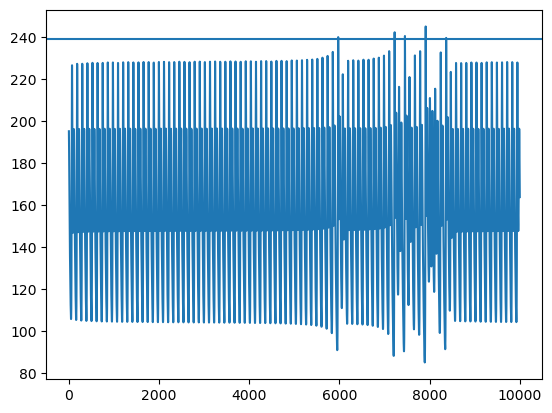

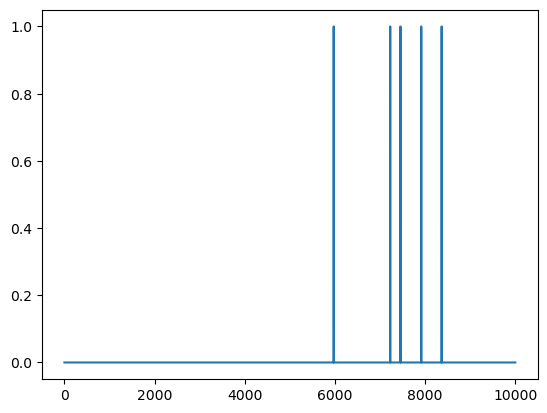

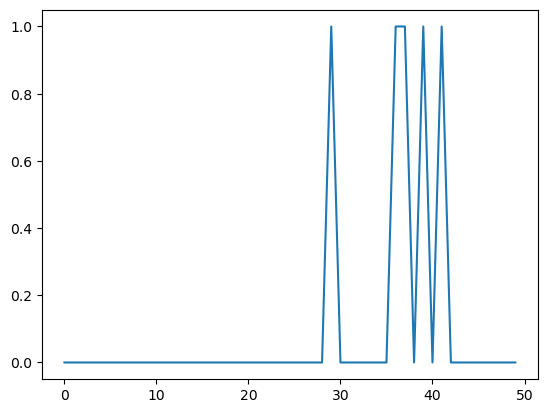

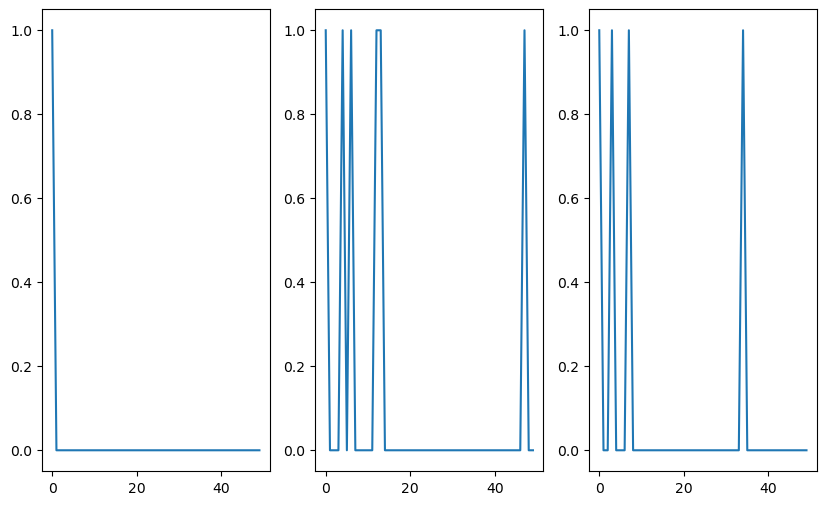

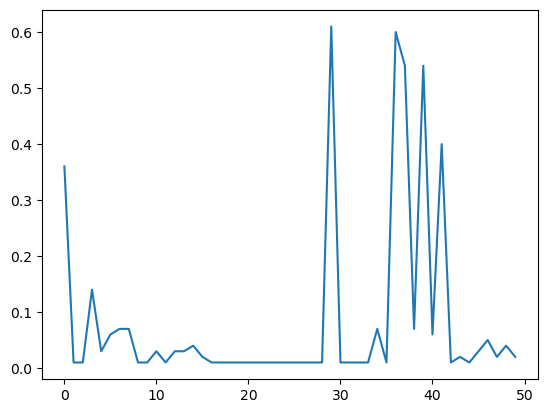

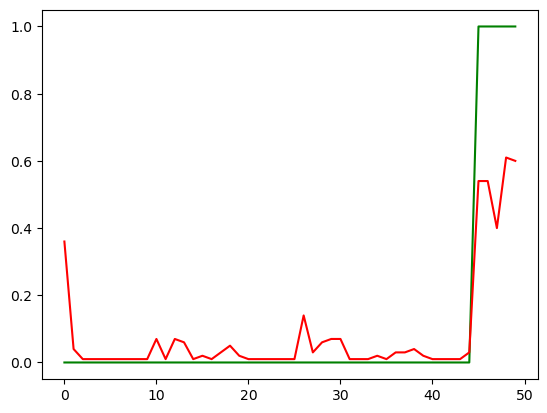

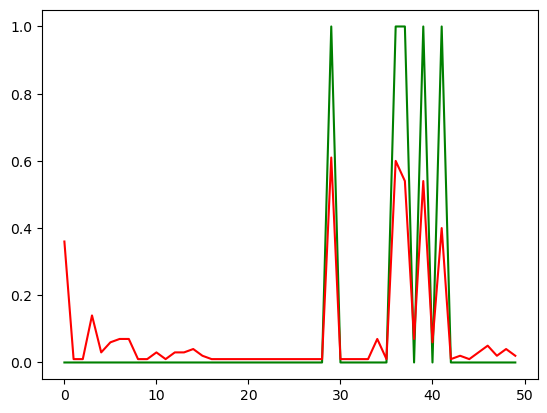

In [9]:
for daynum, rho in enumerate(rhos[1:2]):
    simulator = Lorenz63Simulator(rho=rho,rng=rng)

    truth_series, perturbed_series_list = simulator.run_simulations(
        truth_initial_state, num_steps, dt, spinup_time, num_perturbations, perturbation_scale,
        drift_minmax=drift_minmax)

    # Uncommon is doing a percentile based on day, not dataset
    # thresh = np.percentile(truth_series, pc)

    if daynum == 0:
        fig,ax = plt.subplots(1)
        ax.plot(truth_series)
        ax.axhline(y=thresh)
        # fig.show()
    
    exceed_raw = truth_series > thresh
    
    if daynum == 0:
        fig,ax = plt.subplots(1)
        ax.plot(exceed_raw)
        # fig.show()
        
    exceed_filt = subsample(maximum_filter1d(exceed_raw, size=filt_len, mode="constant", cval=0), filt_len)

    if daynum == 0:
        fig,ax = plt.subplots(1)
        ax.plot(exceed_filt)
        # fig.show()
    
    # Now for the forecasts
    ens_exceed_raw = np.array(perturbed_series_list) > thresh
    ens_exceed_filt = maximum_filter1d(ens_exceed_raw, size=filt_len, mode="constant", cval=0).astype(int)

    if daynum == 0:
        # Look at the first, second, third forecast for change
        fig,axes = plt.subplots(nrows=1,ncols=3,squeeze=True,figsize=(10,6))
        for n,ax in enumerate(axes):
            ax.plot(subsample(ens_exceed_filt[n,:],filt_len))
        # fig.show()
    
    # Generate + bound probabilities 
    probs = subsample(bound_quantise_probs(np.mean(np.array(ens_exceed_filt),axis=0),num_perturbations, quantise_gran=0.01),filt_len)
    
    if daynum == 0:
        fig,ax = plt.subplots(1)
        ax.plot(probs)
        # fig.show()
    

    pass

    # raise Exception

# Verify 

# o = np.array([1,0,0])
# o_b = bound_probs(o,num_perturbations)
# f = np.array([0.6,0.4,0.1])
# dkl = DKL(o,f)
fig,ax = plt.subplots(1)

o = exceed_filt.copy()  
f = probs.copy()
ind = np.argsort(o)
o = o[ind]
f = f[ind]
ax.plot(o,color="green")
ax.plot(f,color="red")

##########################
fig,ax = plt.subplots(1)
ax.plot(exceed_filt,color="green")
ax.plot(probs,color="red")

dkl = DKL(exceed_filt,probs)
print(dkl.compute_unc())
print(dkl.compute_dsc())
print(dkl.compute_rel())
print(dkl.compute_dkl(from_components=False))
print(dkl.compute_dkl(from_components=True))

In [10]:
raise Exception 

Exception: 

In [ ]:
# Verify 
o = np.array([1,0,0])
o_b = bound_probs(o,num_perturbations)
f = np.array([0.6,0.4,0.1])
dkl = DKL(o,f)
# dkl = DKL(exceed_filt,probs)
print(dkl.compute_unc())
print(dkl.compute_dsc())
print(dkl.compute_rel())
print(dkl.compute_dkl(from_components=False))
print(dkl.compute_dkl(from_components=True))